# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


There are 3 main places where this script performs sampling (all 3 steps are performed in each of the 1000 loop iterations): selecting people to be infected, performing primary contact tracing, and performing secondary contact tracing. All 1000 of these loop iterations are shown on the resulting graph.

To select people to be infected, np.random.choice is used to randomly select 100 people (since ATTACK_RATE is 10%) out of our total population of 1000 people, of which 200 attended a wedding and 800 attended a brunch. The sampling here is done without replacement, such that all 100 infected people are different (i.e. the same person cannot be sampled twice). All 1000 people have the same odds of being sampled. Our sampling frame here is all 1000 people across the wedding (200 people) and the brunch (800 people).

For primary contact tracing, we randomly sample from the 100 infected people to determine who gets traced. To do this, we use the np.random.rand function to sample a random number between 0 and 1 (drawn from a uniform distribution) independently for each of the 100 infected people from the previous step. If the random number for an infected person is below TRACE_SUCCESS (0.20), then that individual is included in our sample of primary contact traced individuals. Our sample size can contain anywhere between 0 people and 100 people, depending on what the random numbers from np.random.rand turn out to be. Our sampling frame here is all 100 infected people.

Lastly, for secondary contact tracing, we look at the 200 people from the wedding and the 800 people from the brunch, and for each event we decide whether to add every single infected person from that event to our sample of traced individuals. To decide that, we look at how many infected individuals from each event were primary contact traced in the previous step: if at least 2 people (SECONDARY_TRACE_THRESHOLD = 2) in an event were primary contact traced, then every infected person from that event is contact traced (i.e. everyone at that event who was infected but not initially traced is now added to our sample of traced individuals), making use of the isin function to determine who attended the events being secondary traced. The sample size here will depend on which people were infected at the beginning of the model, since if we decide to secondary contact trace an event we only trace the infected individuals, and an event can have anywhere from 0 to 100 infected individuals (out of the 1000 total people).

Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

As the script is currently written, the results are not reproducible, regardless of how many repetitions are used - every time the script is run, the resulting graph looks different. Increasing the number of repetitions makes the results more consistent between runs of the script (i.e. more reproducible, but not 100% reproducible). With only 10 repetitions, the resulting graphs vary dramatically between different runs of the script. With 1000 repetitions, the graphs are mostly the same between different runs of the script, but still with some apparent differences. With 100 repetitions, the resulting graphs are more consistent with each other compared to 10 repetitions, but less consistent compared to 1000 repetitions.

Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The script needs to produce the same output when run multiple times.

To make the code reproducible, I added the line "np.random.seed(100)" in order to set the RNG seed to an arbitrary but fixed number. Now, the random sampling performed in the script will play out the exact same way every time the script is run, because each run of the script uses the same RNG seed. Because of this change, the graph produced by the script is always the exact same between runs of the script (for a given number of repetitions), meaning that the results of the script are now fully reproducible.

## Code

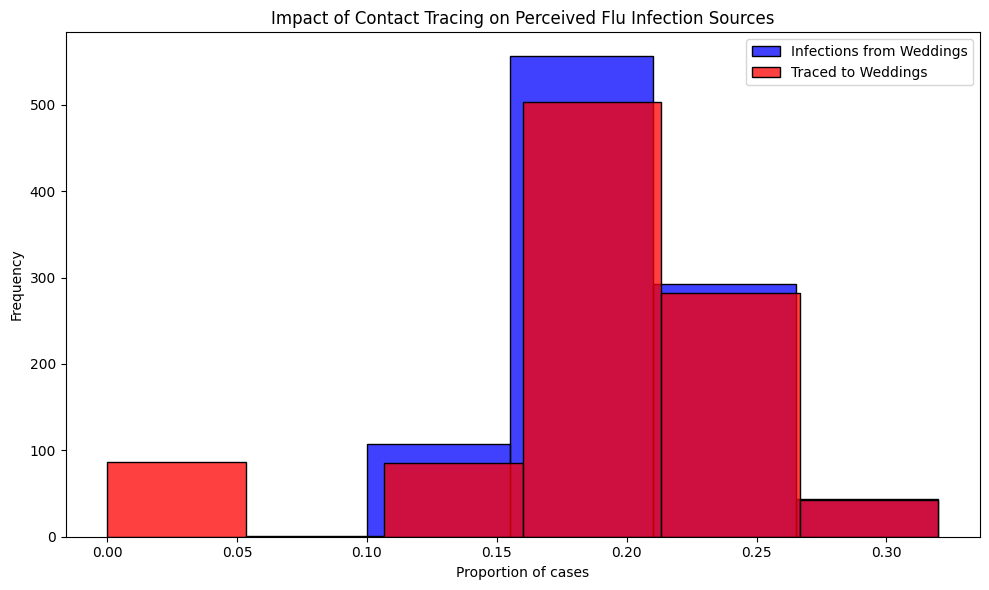

In [88]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2


# Set a seed so that different runs of the script perform random sampling the same way
np.random.seed(100)


def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 06 January 2026`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
